In [1]:
!pip install transformers==4.5.0 fugashi==1.1.0 ipadic==1.0.0 

     |████████████████████████████████| 2.1 MB 4.2 MB/s 
     |████████████████████████████████| 486 kB 54.7 MB/s 
     |████████████████████████████████| 13.4 MB 45.9 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 895 kB 55.0 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=2c778122cb95b355fa21e030e33fee98cc48b092cfe7e91ff73787a87c3b27d8
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [2]:
import numpy as np
import torch
from transformers import BertJapaneseTokenizer, BertModel, BertConfig
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [36]:
# モジュール
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME) 
config = BertConfig.from_pretrained(MODEL_NAME) 
config.output_hidden_states = True 
config.output_attentions = True 
model = BertModel.from_pretrained(MODEL_NAME, config=config)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [8]:
from IPython.display import HTML

# 赤字ハイライトするためのhtmlを作成（トークン単位の呼び出しを想定）
def highlight(word, attention):
  html_color = "#%02X%02X%02X" % (225, int(225*(1-attention)), int(225*(1-attention)))
  return "<span style='background-color:{}'> {}</span>".format(html_color, word)

# 文章にアテンションに応てハイライトするhtmlを作成（idからtoken変換された文章単位の呼び出しを想定）
def get_highlighted_text(words, attentions):
  html = ""
  for word, attention in zip(words, attentions):
    html += highlight(word, attention)
  html += "<br><br>"
  return html

# 文章にアテンションに応てハイライトするhtmlを作成（idからtoken変換された文章配列単位の呼び出しを想定）
def get_highlighted_textlist(ary_words, ary_attentions):
  html = ""
  for words, attentions in zip(ary_words, ary_attentions):
    html += get_highlighted_text(words, attentions)
  return html

In [35]:
# 前処理
text = "今日は晴れ。" 
encode = tokenizer(text, max_length=13, padding='max_length', truncation=True)
input = torch.LongTensor(encode['input_ids']).unsqueeze(0) 

# 推論
with torch.no_grad():
  output = model(input)
last_attentions = output[3][11] 
avg_attentions = last_attentions[0, :, 0, :].mean(dim=0)

# アテンション可視化
words = tokenizer.convert_ids_to_tokens(encode['input_ids'])
html = get_highlighted_text(words, avg_attentions)
#print(html)
HTML(html)

In [31]:
# 前処理
text = ["今日は晴れ。", "明日は雨。"]
encode = tokenizer(text, max_length=13, padding='max_length', truncation=True)

# 推論
with torch.no_grad():
  output = model(torch.tensor(encode['input_ids']))
last_attentions = output[3][11]
ary_avg_attentions = last_attentions[:, :, 0, :].mean(dim=1)

# アテンション可視化
ary_words = [tokenizer.convert_ids_to_tokens(torch.tensor(encode['input_ids'])[i]) for i in range(len(encode['input_ids']))]
html = get_highlighted_textlist(ary_words, ary_avg_attentions)
#print(html)
HTML(html)

In [64]:
# アテンションの結合
cat_attentions = torch.tensor([])
for i in range(len(ary_avg_attentions)):
  cat_attentions = torch.cat([cat_attentions, ary_avg_attentions[i]], dim=0)

<Figure size 144x144 with 0 Axes>

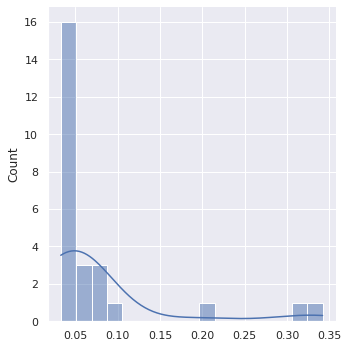

In [63]:
# アテンションの可視化
plt.figure(figsize=(2,2))
sns.displot(cat_attentions.numpy(), kde=True)
#sns.displot(ary_avg_attentions[0].numpy(), kde=True)
plt.show()